# BERT

In [260]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 1. Data

In [261]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("nuvocare/WikiMedical_sentence_similarity")


In [262]:
# Define the split sizes
train_size = 85
test_size = 15  # Explicit for clarity, though it's simply 100 - 85

# Apply the split to both 'train' and 'test' sets in the DatasetDict
new_train = dataset['train'].select(range(train_size))
new_test = dataset['train'].select(range(train_size, train_size + test_size))

# Additionally, if you wish to apply the split to the original 'test' dataset as well, you can do:
# For clarity, showing how to reassign within the DatasetDict, but typically, you adjust only the 'train' part for such operations
dataset['train'] = new_train
dataset['test'] = dataset['test'].select(range(test_size))

# Confirming the new sizes
print(f"New Train dataset size: {len(dataset['train'])}")
print(f"New Test dataset size: {len(dataset['test'])}")



New Train dataset size: 85
New Test dataset size: 15


In [263]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 85
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 15
    })
})

## 2. Preprocessing

### Tokenization and numericalization

In [264]:
from datasets import load_dataset
import numpy as np
import random
import re

# Define your transformation function
def transform_data(example):
    text1 = re.sub("[.,!?\\-]", '', example['text1'].lower())
    text2 = re.sub("[.,!?\\-]", '', example['text2'].lower())
    label = example['label']

    if np.random.random() < 0.5:
        return {'text1': text1, 'text2': text2, 'isNext': label == 1}  # Assuming 1 indicates similarity
    else:
        return {'text1': text2, 'text2': text1, 'isNext': label == 1}  # Flip text1 and text2

# Assuming 'dataset' is your DatasetDict
# Apply the transformation directly to each split in the DatasetDict
transformed_dataset = {
    split: dataset[split].map(transform_data, remove_columns=['text1', 'text2', 'label'])
    for split in dataset.keys()
}

# Now, 'transformed_dataset' should be correctly transformed
print(f"Transformed Train dataset size: {len(transformed_dataset['train'])}")
print(f"Transformed Test dataset size: {len(transformed_dataset['test'])}")


Transformed Train dataset size: 85
Transformed Test dataset size: 15


In [265]:
transformed_dataset

{'train': Dataset({
     features: ['text1', 'text2', 'isNext'],
     num_rows: 85
 }),
 'test': Dataset({
     features: ['text1', 'text2', 'isNext'],
     num_rows: 15
 })}

In [266]:
import torch
from datasets import load_dataset
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

# Load the 'basic_english' tokenizer
tokenizer = get_tokenizer('basic_english')
# Adjust the tokenize_data function to handle batch processing
def tokenize_data(batch, tokenizer):
    # Tokenize each text in the batch for text1 and text2
    # text1_tokens = [tokenizer(text) for text in batch['text1']]
    # text2_tokens = [tokenizer(text) for text in batch['text2']]
    
    text1_tokens = [tokenizer(re.sub("[.,!?\\-]", '', text.lower())) for text in batch['text1']]
    text2_tokens = [tokenizer(re.sub("[.,!?\\-]", '', text.lower())) for text in batch['text2']]


    # Return a dictionary with the tokenized texts
    return {'text1_tokens': text1_tokens, 'text2_tokens': text2_tokens}

# Apply tokenization to each split in your transformed dataset
tokenized_dataset = {
    split: transformed_dataset[split].map(lambda batch: tokenize_data(batch, tokenizer), batched=True, remove_columns=['text1', 'text2'])
    for split in transformed_dataset.keys()
}

# Proceed with building the vocab
special_tokens = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']

# Since build_vocab_from_iterator expects a flat iterator of tokens, you need to flatten the token lists
def flat_map(tokens_lists):
    for tokens in tokens_lists:
        for token in tokens:
            yield token

# Adjust the call to build_vocab_from_iterator
vocab = build_vocab_from_iterator(
    flat_map(tokenized_dataset['train']['text1_tokens'] + tokenized_dataset['train']['text2_tokens']),
    specials=special_tokens
)
vocab.set_default_index(vocab['[UNK]'])

# Save vocab for later use
torch.save(vocab, './model/vocab.pth')


Map: 100%|██████████| 15/15 [00:00<00:00, 534.06 examples/s]


In [267]:
print(f"Total number of tokens in vocab: {len(vocab)}")


Total number of tokens in vocab: 93


In [268]:
tokens_to_check = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]', 'the', 'of', 'and']
for token in tokens_to_check:
    print(f"Index of '{token}': {vocab[token]}")


Index of '[PAD]': 0
Index of '[CLS]': 1
Index of '[SEP]': 2
Index of '[MASK]': 3
Index of '[UNK]': 4
Index of 'the': 4
Index of 'of': 4
Index of 'and': 4


In [269]:
tokenized_dataset['train'][0]

{'isNext': False,
 'text1_tokens': ['econometric',
  'studies',
  'have',
  'shown',
  'that',
  'this',
  'effect',
  'cannot',
  'be',
  'explained',
  'by',
  'a',
  'variety',
  'of',
  'alternative',
  'factors',
  'including',
  'differential',
  'trends',
  'across',
  'areas',
  'changing',
  'crop',
  'prices',
  'shifts',
  'in',
  'certain',
  'educational',
  'and',
  'health',
  'policies',
  'and',
  'the',
  'effect',
  'of',
  'malaria',
  'eradication',
  'no',
  'significant',
  'contemporaneous',
  'results',
  'were',
  'found',
  'for',
  'adults',
  'who',
  'should',
  'have',
  'benefited',
  'less',
  'from',
  'the',
  'intervention',
  'owing',
  'to',
  'their',
  'substantially',
  'lower',
  '(',
  'prior',
  ')',
  'infection',
  'rates',
  'the',
  'program',
  'nearly',
  'eradicated',
  'hookworm',
  'and',
  'would',
  'flourish',
  'afterward',
  'with',
  'new',
  'funding',
  'as',
  'the',
  'rockefeller',
  'foundation',
  'international',
  'hea

## 3. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”. 

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred` 

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`. 

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [270]:
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Assuming vocab and transformed_dataset are already defined and loaded

def make_batch(dataset, vocab, max_mask, max_len):
    data = []
    
    for example in tqdm(dataset):
        # Transform the list of tokens to list of token indices based on vocab
        tokens_a = [vocab[token] if token in vocab else vocab['[UNK]'] for token in example['text1_tokens']]
        tokens_b = [vocab[token] if token in vocab else vocab['[UNK]'] for token in example['text2_tokens']]

        # 1. Token embedding - add CLS and SEP
        input_ids = [vocab['[CLS]']] + tokens_a + [vocab['[SEP]']] + tokens_b + [vocab['[SEP]']]

        # 2. Segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

        # Ensure length does not exceed max_len
        input_ids = input_ids[:max_len]
        segment_ids = segment_ids[:max_len]

        # 3. Predicted mask positions
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != vocab['[CLS]'] and token != vocab['[SEP]']]
        np.random.shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []

        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            rand_val = np.random.random()
            if rand_val < 0.1:
                input_ids[pos] = vocab[vocab.get_itos()[np.random.randint(5, len(vocab) - 1)]]
            elif rand_val < 0.8:
                input_ids[pos] = vocab['[MASK]']

        # 4. Pad the sentences and masks to max_len
        n_pad = max_len - len(input_ids)
        input_ids.extend([vocab['[PAD]']] * n_pad)
        segment_ids.extend([0] * n_pad)

        n_pad = max_mask - len(masked_tokens)
        masked_tokens.extend([0] * n_pad)
        masked_pos.extend([0] * n_pad)

        instance = [input_ids, segment_ids, masked_tokens, masked_pos, [int(example['isNext'])]]
        instance = [torch.LongTensor(i) for i in instance]
        data.append(instance)
        
    return data

def custom_collate_fn(batch):
    input_ids = torch.stack([item[0] for item in batch])
    segment_ids = torch.stack([item[1] for item in batch])
    masked_tokens = torch.stack([item[2] for item in batch])
    masked_pos = torch.stack([item[3] for item in batch])
    isNext = torch.stack([item[4] for item in batch])
    return input_ids, segment_ids, masked_tokens, masked_pos, isNext

# Parameters
batch_size = 16
max_mask = 5
max_len = 512

# Prepare the data
train_data = make_batch(tokenized_dataset['train'], vocab, max_mask, max_len)
val_data = make_batch(tokenized_dataset['test'], vocab, max_mask, max_len)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=custom_collate_fn)

# Example usage
for input_ids, segment_ids, masked_tokens, masked_pos, isNext in train_loader:
    break  # This just demonstrates how to iterate over one batch


  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 547.44it/s]


In [271]:
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext

(torch.Size([16, 512]),
 torch.Size([16, 512]),
 torch.Size([16, 5]),
 torch.Size([16, 5]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [0],
         [0],
         [1]]))

## 4. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 4.1 Embedding

<img src = "./figures/BERT_embed.png" width=500>

In [272]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 4.2 Attention mask

In [273]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [274]:
print(get_attn_pad_mask(input_ids, input_ids, 'cpu').shape)

torch.Size([16, 512, 512])


## 4.3 Encoder

The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [275]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [276]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

Here is the Multiheadattention.

In [277]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

Here is the PoswiseFeedForwardNet.

In [278]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

## 4.4 Putting them together

In [279]:
class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        
        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

## 5. Training

In [280]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [281]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [282]:
model = BERT(n_layers, n_heads, d_model, d_ff, d_k, n_segments, len(vocab), max_len, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # BERT paper used 5e-5

In [283]:
def train(model, data, optimizer, criterion, device):
    epoch_loss = []
    model.train()

    for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Training: '):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        masked_tokens = masked_tokens.to(device)
        masked_pos = masked_pos.to(device)
        isNext = isNext.flatten().to(device)
        logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
        #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
        #logits_nsp: (bs, yes/no) ==> (6, 2)

        #1. mlm loss
        #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        #2. nsp loss
        #logits_nsp: (bs, 2) vs. isNext: (bs, )
        loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
        
        #3. combine loss
        loss = loss_lm + loss_nsp
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    return np.mean(epoch_loss)

In [284]:
def evaluate(model, data, criterion, device):
    epoch_loss = []
    model.eval()

    with torch.no_grad():  # set the 'requires_grad' to False to speed up computation and reduce memory cost
        for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Evaluate: '):
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            masked_tokens = masked_tokens.to(device)
            masked_pos = masked_pos.to(device)
            isNext = isNext.flatten().to(device)
            logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
            #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
            #logits_nsp: (bs, yes/no) ==> (6, 2)

            #1. mlm loss
            #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
            loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
            loss_lm = (loss_lm.float()).mean()
            #2. nsp loss
            #logits_nsp: (bs, 2) vs. isNext: (bs, )
            loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
            
            #3. combine loss
            loss = loss_lm + loss_nsp
            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [285]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [286]:
import time
save_path = './model/bert_best_model.pt'
num_epoch = 10

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    lr_scheduler.step(val_loss)

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model only when its validation loss is lower than all its predecessors
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save([model.params, model.state_dict()], save_path)  # save the model's parameters and state to a file

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Epoch: 01 | Time: 2m 51s
	Train Loss: 23.529
	 Val. Loss: 27.009


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


Epoch: 02 | Time: 2m 46s
	Train Loss: 12.805
	 Val. Loss: 9.155


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Epoch: 03 | Time: 2m 56s
	Train Loss: 8.529
	 Val. Loss: 7.790


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


Epoch: 04 | Time: 2m 34s
	Train Loss: 10.065
	 Val. Loss: 6.322


Evaluate: 100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


Epoch: 05 | Time: 2m 38s
	Train Loss: 6.418
	 Val. Loss: 7.046


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


Epoch: 06 | Time: 2m 25s
	Train Loss: 8.742
	 Val. Loss: 6.443


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Epoch: 07 | Time: 2m 34s
	Train Loss: 7.089
	 Val. Loss: 5.904


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Epoch: 08 | Time: 3m 13s
	Train Loss: 5.906
	 Val. Loss: 5.408


Evaluate: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch: 09 | Time: 2m 41s
	Train Loss: 5.686
	 Val. Loss: 4.698


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Epoch: 10 | Time: 2m 34s
	Train Loss: 4.103
	 Val. Loss: 4.110


Text(0, 0.5, 'loss')

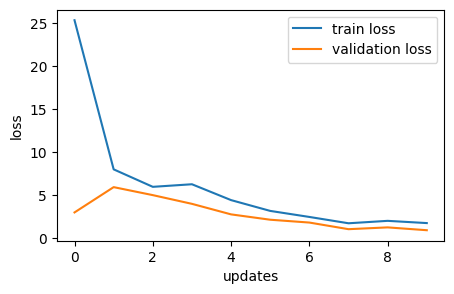

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'validation loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 6. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

In [104]:
# load the model and all its hyperparameters
params, state = torch.load(save_path)
model = BERT(**params, device=device).to(device)
model.load_state_dict(state)

<All keys matched successfully>

In [107]:
vocab = torch.load('./model/vocab')

In [108]:
len(vocab)

17825

Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 15
})

In [109]:
# Predict mask tokens ans isNext
for input_ids, segment_ids, masked_tokens, masked_pos, isNext in val_loader:
    break

idx = 2
input_ids = input_ids[idx].reshape(1, -1).to(device)
segment_ids = segment_ids[idx].reshape(1, -1).to(device)
masked_tokens = masked_tokens[idx].reshape(1, -1).to(device)
masked_pos = masked_pos[idx].reshape(1, -1).to(device)
isNext = isNext[idx].item()

print([vocab.get_itos()[w.item()] for w in input_ids[0] if vocab.get_itos()[w.item()] != '[PAD]'])

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy() 
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in masked_tokens[0] if pos.item() != 0])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predicted masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in logits_lm if pos.item() != 0])
print('predicted masked tokens list : ', [pos for pos in logits_lm if pos.item() != 0])

#predict nsp
logits_nsp = logits_nsp.data.cpu().max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ', True if logits_nsp else False)

['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'and', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'and', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'and', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]

In [112]:
test_data

Dataset({
    features: ['text1', 'text2', 'label'],
    num_rows: 15
})

In [250]:
import torch

# Load the model, vocabulary, and parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
params, state_dict = torch.load('./model/bert.pt', map_location=device)
vocab = torch.load('./model/vocab.pth', map_location=device)

# Initialize the model and load the saved state
model = BERT(**params, device=device).to(device)
model.load_state_dict(state_dict)
model.eval()



BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(93, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decoder)

In [247]:
import torch
import random

def process_data_point(idx, input_ids, segment_ids, masked_tokens, masked_pos, isNext, device, model, vocab):
    """
    Process a single data point and print the prediction results.
    """
    # Reshape and send to device
    input_ids = input_ids[idx].reshape(1, -1).to(device)
    segment_ids = segment_ids[idx].reshape(1, -1).to(device)
    masked_tokens = masked_tokens[idx].reshape(1, -1).to(device)
    masked_pos = masked_pos[idx].reshape(1, -1).to(device)
    isNext = isNext[idx].item()

    print([vocab.get_itos()[w.item()] for w in input_ids[0] if vocab.get_itos()[w.item()] != '[PAD]'])

    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

    # Process language model logits
    logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy()
    print('Masked tokens (words):', [vocab.get_itos()[pos.item()] for pos in masked_tokens[0] if pos.item() != 0])
    print('Predicted masked tokens (words):', [vocab.get_itos()[pos.item()] for pos in logits_lm if pos.item() != 0])

    # Process next sentence prediction logits
    logits_nsp = logits_nsp.data.cpu().max(1)[1][0].data.numpy()
    print('isNext:', True if isNext else False)
    print('Predicted isNext:', True if logits_nsp else False)

# Predict mask tokens and isNext
try:
    for input_ids, segment_ids, masked_tokens, masked_pos, isNext in val_loader:
        # Randomly select an index from the batch
        batch_size = input_ids.size(0)
        idx = random.randint(0, batch_size - 1)

        process_data_point(idx, input_ids, segment_ids, masked_tokens, masked_pos, isNext, device, model, vocab)
        break  # Only process one batch for demonstration
except Exception as e:
    print(f"Error processing batch: {e}")


['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '(', '[UNK]', ')', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]'

In [210]:
# The specific input example you provided
input_example = {
    'text1': 'fsfsdfsfssfs econometric studies have shown that this effect cannot be explained by a variety of alternative factors including differential trends across areas changing crop prices shifts in certain educational and health policies and the effect of malaria eradication no significant contemporaneous results were found for adults who should have benefited less from the intervention owing to their substantially lower (prior) infection rates the program nearly eradicated hookworm and would flourish afterward with new funding as the rockefeller foundation international health divisionthe rfs hookworm campaign in mexico showed how science and politics play a role in developing health policies it brought together government officials health officials public health workers rockefeller officials and the community this campaign was launched to eradicate hookworms in mexico although the campaign did not focus on longterm treatments it did set the terms of the relationship between mexico and the rockefeller foundation the scientific knowledge behind this campaign helped shape public health policies improved public health and built a strong relationship between us and mexicoin the 1920s hookworm eradication reached the caribbean and latin america where great mortality was reported among people in the west indies towards the end of the 18th century as well as through descriptions sent from brazil and various other tropical and subtropical regions treatments\ntreatment in the early 20th century relied on the use of epsom salt to reduce protective mucus followed by thymol to kill the worms by the 1940s tetrachloroethylene was the leading method',
    'text2': '"spinraza access by country" treatsma 18 october 2018 retrieved 20190528',
    'isNext': False
}

# Assuming 'tokenizer', 'vocab', and 'device' are already defined and loaded

# Tokenize the input texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])


# Convert tokens to vocab indices
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text2_tokens]

# Prepare model inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)
masked_pos = torch.tensor([]).unsqueeze(0).to(device)  # No masked tokens in the inference example

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

# Predicted isNext flag and confidence score
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext = "Yes" if input_example['isNext'] else "No"

# Display results
print("Original Text 1:\n", input_example['text1'])
print("\nOriginal Text 2:\n", input_example['text2'])
print(f"\nAre sentences next? {original_isNext} (Original)")
print(f"\nPredicted NSP: {predicted_isNext_text}")
print(f"\nNSP Score: {confidence_score:.4f} (Confidence)")

Original Text 1:
 fsfsdfsfssfs econometric studies have shown that this effect cannot be explained by a variety of alternative factors including differential trends across areas changing crop prices shifts in certain educational and health policies and the effect of malaria eradication no significant contemporaneous results were found for adults who should have benefited less from the intervention owing to their substantially lower (prior) infection rates the program nearly eradicated hookworm and would flourish afterward with new funding as the rockefeller foundation international health divisionthe rfs hookworm campaign in mexico showed how science and politics play a role in developing health policies it brought together government officials health officials public health workers rockefeller officials and the community this campaign was launched to eradicate hookworms in mexico although the campaign did not focus on longterm treatments it did set the terms of the relationship betwee

In [214]:
import torch
import random

# Assuming 'model', 'tokenizer', 'vocab', 'device' are correctly defined

# Function to mask tokens
def mask_tokens(tokens, vocab, probability=0.15):
    masked_tokens = []
    masked_positions = []
    for i, token in enumerate(tokens):
        if random.random() < probability:
            masked_tokens.append('[MASK]')
            masked_positions.append(i)
        else:
            masked_tokens.append(token)
    return masked_tokens, masked_positions

# Randomly select an example from the test dataset
random_idx = random.randint(0, len(transformed_dataset['test']) - 1)
input_example = transformed_dataset['test'][random_idx]

# Tokenize the texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])

# Mask tokens
masked_text1_tokens, _ = mask_tokens(text1_tokens, vocab)
masked_text2_tokens, _ = mask_tokens(text2_tokens, vocab)

# Convert tokens to indices, handling unknown tokens
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in masked_text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in masked_text2_tokens]

# Prepare inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)

# Inference
model.eval()
with torch.no_grad():
    _, logits_nsp = model(input_ids, segment_ids, torch.tensor([]).unsqueeze(0).to(device))

# Display results
print("Original Text 1:", input_example['text1'])
print("Original Text 2:", input_example['text2'])
print("Masked Text 1:", ' '.join(masked_text1_tokens))
print("Masked Text 2:", ' '.join(masked_text2_tokens))
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext_text = "Yes" if input_example['isNext'] else "No"
print(f"Are sentences next? {original_isNext_text} (Original)")
print(f"Predicted NSP: {predicted_isNext_text}")
print(f"NSP Score: {confidence_score:.4f} (Confidence)")


Original Text 1: lincomycin is a lincosamide antibiotic that comes from the actinomycete streptomyces lincolnensis a related compound clindamycin is derived from lincomycin by using thionyl chloride to replace the 7hydroxy group with a chlorine atom with inversion of chirality it was released for medical use in september 1964 uses
although similar in antibacterial spectrum and mechanism of action to macrolides lincomycin is also effective against other organisms including actinomycetes and some species of mycoplasma and plasmodiumhowever because of its adverse effects and toxicity it is rarely used today and reserved for patients allergic to penicillin or where bacteria have developed resistance clinical pharmacology
intramuscular administration of a single dose of 600 mg of lincomycin produces average peak serum levels of 116 µg/ml at 60 min and maintains therapeutic levels for 17 h to 20 h for most susceptible grampositive organisms urinary excretion after this dose ranges from 18% t

In [258]:
# Select a random sample from transformed_dataset['test']
random_idx = randint(0, len(transformed_dataset['test']) - 1)
input_example = transformed_dataset['test'][random_idx]


# Assuming 'tokenizer', 'vocab', and 'device' are already defined and loaded

# Tokenize the input texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])


# Convert tokens to vocab indices
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text2_tokens]

# Prepare model inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)
masked_pos = torch.tensor([]).unsqueeze(0).to(device)  # No masked tokens in the inference example

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

# Predicted isNext flag and confidence score
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext = "Yes" if input_example['isNext'] else "No"

# Display results
print("Original Text 1:\n", input_example['text1'])
print("\nOriginal Text 2:\n", input_example['text2'])
print(f"\nAre sentences next? {original_isNext} (Original)")
print(f"\nPredicted NSP: {predicted_isNext_text}")
print(f"\nNSP Score: {confidence_score:.4f} (Confidence)")

Original Text 1:
 these and other novel genes (dpti dptj) are believed to be involved in supplying the nonproteinogenic amino acids l3methylglutamic acid and kyn; they are located next to the nrps genesthe decanoic acid portion of daptomycin is synthesized by fatty acid synthase machinery (figure 2) posttranslational modification of the apoacyl carrier protein (acp thiolation or t domain) by a phosphopantetheinyltransferase (pptase) enzyme catalyzes the transfer of a flexible phosphopantetheine arm from coenzyme a to a conserved serine in the acp domain through a phosphodiester linkage the holoacp can provide a thiol on which the substrate and acyl chains are covalently bound during chain elongations the two core catalytic domains are an acyltransferase (at) and a ketosynthase (ks) the at acts upon a malonylcoa substrate and transfers an acyl group to the thiol of the acp domain this net transthiolation is an energyneutral step next the acylsacp gets transthiolated to a conserved cyste

In [287]:
model

BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(93, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decoder)